In [1]:
!pip install -q google-generativeai

In [2]:
from google.colab import userdata
import google.generativeai as genai
import time

In [3]:
gemini_api_key = userdata.get('gemini_api_key')
genai.configure(api_key=gemini_api_key)

In [4]:
# chatBot
def mental_health_chatBot(user_text, analysis_result):
         # input validation
  if not user_text.strip():
    return "Please enter a valid question or message."

  if len(user_text) > 1000:
    return "Your message is too long. Please keep it under 1000 characters."

  time.sleep(3)     # wait 3 second before send the request

  try:
    model = genai.GenerativeModel("gemini-1.5-flash")
     # prompt with user_text, sentiment and emotions
    prompt = f"""You are a compassionate and understanding mental health support assistant.
      Your role is to respond in a way that provides comfort, encouragement, and practical guidance.
      Be empathetic and non-judgmental. Keep the tone warm and supportive.

      User's message:
      "{user_text}"

      Detected Sentiment: {analysis_result['sentiment']} (score: {analysis_result['sentiment_score']:.2f})
      Detected Primary Emotion: {analysis_result['emotion']}
      All Emotion Scores: {', '.join([f"{e['label']}={e['score']:.2f}" for e in analysis_result['all_emotions']])}

    Please give a response that addresses the user's feelings and helps them feel supported."""

    response = model.generate_content(prompt, request_options={"timeout": 10})      #Time out after 10 second
    return response.text

  except Exception as e:
    if "429" in str(e):
      wait_time = 120
      print(f"Rate limit hit. Retrying in {wait_time} seconds...")
      time.sleep(wait_time)
    else:
      return f"Error : {str(e)}"


In [5]:
!pip install textblob
!pip install transformers
!pip install torch
!python -m textblob.download_corpora

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [6]:
from textblob import TextBlob
from transformers import pipeline

In [20]:
# emotion classifier
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None
)

Device set to use cuda:0


In [21]:
# analyze user input

def analyze_text(user_text):
  # sentiment analysis

  blob = TextBlob(user_text)
  sentiment_score = blob.sentiment.polarity
  sentiment_label = "Positive" if sentiment_score > 0 else "Negative" if sentiment_score < 0 else "Neutral"
  # emotion analysis
  emotion_score = emotion_classifier(user_text)[0]
  emotion_score_sorted = sorted(emotion_score, key = lambda x: x['score'], reverse = True)
  top_emotion = emotion_score_sorted[0]['label']
  return {
      "sentiment" : sentiment_label,
      "sentiment_score" : sentiment_score,
      "emotion" : top_emotion,
      "all_emotions" : emotion_score_sorted
  }

In [9]:
import matplotlib.pyplot as plt


In [22]:
# plot sentiments pie chart

def plot_sentiments(analysis_result):
  sentiment_score = analysis_result['sentiment_score']

  if sentiment_score > 0:
    positive = sentiment_score * 100
    negative = 0
    neutral = 100 - positive
  elif sentiment_score < 0:
    negative = abs(sentiment_score) * 100
    positive = 0
    neutral = 100 - negative
  else:
    positive = 0
    negative = 0
    neutral = 100

  sentiment_labels = ["Positive", "Negative", "Neutral"]
  sentiment_values = [positive, negative, neutral]
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.pie(sentiment_values, labels=sentiment_labels, autopct='%1.1f%%', startangle=90)
  plt.title("Sentiment Distribution")
  plt.show()

In [23]:
# emotion pie chart

def plot_emotions(analysis_result):
  emotion_labels = [e['label'] for e in analysis_result['all_emotions']]
  emotion_scores = [e['score'] for e in analysis_result['all_emotions']]
  plt.subplot(1, 2, 2)
  plt.pie(emotion_scores, labels=emotion_labels, autopct='%1.1f%%', startangle=90)
  plt.title("Emotion Distribution")

  plt.show()

In [24]:
# beautify response

def beautify_response(text):
  text = text.replace("**", " ")
  text = text.replace(":", ":\n")
  text = text.replace("*", "\n • ")
  text = text.replace("\n\n", "\n")
  return text

In [25]:
#user_input

user_text = input("I am your personal AI assistant. Ask me anything. ")
analysis_result = analyze_text(user_text)        # sentiment and emotional analysis

ans = mental_health_chatBot(user_text, analysis_result)        # chatBot

final_response = beautify_response(ans)        # beautify response

I am your personal AI assistant. Ask me anything. I don’t think this plan will work; it’s just a waste of ti


In [16]:
print(final_response)

It sounds like you're feeling really discouraged right now, and that's completely understandable.  It's tough when a plan you've put effort into doesn't seem to be working as hoped.  It can be frustrating and even feel like a waste of time.  
Tell me a little more about what specifically isn't working for you with the plan.  Sometimes, just talking it through can help identify small adjustments that can make a big difference.  Perhaps we can brainstorm some alternative approaches together, or explore ways to modify the current plan to better suit your needs.  
Remember, it's okay to feel this way.  It doesn't mean you've failed, it just means we might need to try a different approach.  We can work through this together.  Let's not give up just yet.  What's one small step we could take to explore this further?



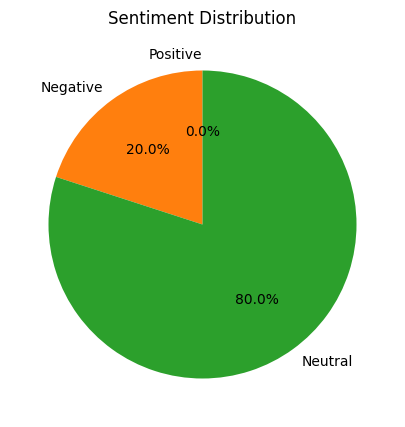

In [26]:
plot_sentiments(analysis_result)

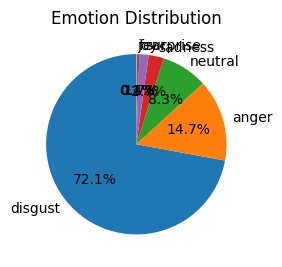

In [27]:
plot_emotions(analysis_result)